In [1]:
%matplotlib inline
import sys
sys.path.append("src") # add the source dir

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from src.pipeline import Pipeline, MultiPipeline
from mne_bids import BIDSPath
import mne

We will do an individual Analysis of subject 30, afterthat, we will statistically test all the other subjects

In [3]:
#set bids path
bids_root = os.path.join('data', 'P3')
bids_path = BIDSPath(subject='030', session='P3', task='P3',datatype='eeg', suffix='eeg', root=bids_root)
pipeline = Pipeline(bids_path)

In [4]:
from preprocessing import CleaningData, SimpleMNEFilter, PrecomputedICA

pipeline.load_data()
pipeline.set_montage()
pipeline.set_custom_events_mapping(task='P3') # mapping for P3 task

INFO:root:Loading Data
INFO:root:Standard 1020 montage and EOG channels are set


### We will use our pipeline to perform following operations
- Loading bad segments, bad channels
- Apply filtering
- Loading Precomputed ICA

In [5]:
pipeline.make_pipeline([SimpleMNEFilter(.5, 50, 'firwin'), CleaningData(bids_path), PrecomputedICA(bids_path)])

INFO:root:*****Proceesing for subject: 030*****
INFO:root:Applying filtering
INFO:root:Applying cleaning
INFO:root:Applying ICA
INFO:root:Processed subject 030



In [6]:
# We take the values below based on the erp core paper https://doi.org/10.1016/j.neuroimage.2020.117465
pipeline.apply_rereferencing(['P9', 'P10'])
pipeline.apply_resampling(256)

INFO:root:Applying re-referencing
INFO:root:Applying resampling


# ERP Peak Analysis for subject 30

In [7]:
from erpanalysis import ERPAnalysis
# Although in the erp paper, Authors mentions about cutting the epochs from (-0.2, 0.8) 
# and keeping baseline from (-200, 0), we have decided not to proced with these value and rather use our own baseline and time window
tmin = -0.1
tmax = 0.8
baseline = (None, 0)


## We will create epochs from custom mappings. We have 

- Stimulus: A, B, C, D, E

- Conditions: Rare, Frequent

In [8]:
# we will use our own class for performing peak analysis. The classes encapsulates the MNE.epochs class and has few other functions
erp = ERPAnalysis(tmin, tmax)
erp.compute_epochs(pipeline.raw, pipeline.events, pipeline.event_ids, baseline=baseline, reject_by_annotation=True)

<Epochs |  295 events (all good), -0.101562 - 0.800781 sec, baseline -0.101562 – 0 sec, ~17.3 MB, data loaded,
 'response/correct/201': 145
 'response/error/202': 4
 'stimulus/A/freq/12': 4
 'stimulus/A/freq/13': 6
 'stimulus/A/freq/14': 8
 'stimulus/A/freq/15': 7
 'stimulus/A/rare/11': 5
 'stimulus/B/freq/21': 6
 'stimulus/B/freq/23': 10
 'stimulus/B/freq/24': 3
 'stimulus/B/freq/25': 8
 'stimulus/B/rare/22': 8
 'stimulus/C/freq/31': 7
 'stimulus/C/freq/32': 9
 'stimulus/C/freq/34': 4
 'stimulus/C/freq/35': 10
 'stimulus/C/rare/33': 7
 'stimulus/D/freq/41': 5
 'stimulus/D/freq/42': 5
 'stimulus/D/freq/43': 3
 'stimulus/D/freq/45': 0
 'stimulus/D/rare/44': 4
 'stimulus/E/freq/51': 4
 'stimulus/E/freq/52': 9
 'stimulus/E/freq/53': 3
 'stimulus/E/freq/54': 5
 'stimulus/E/rare/55': 6>

# Analysing Epochs

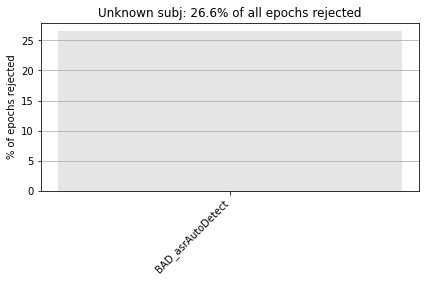

In [9]:
# based on the BAD annotations found using autoreject, we rejected 26,6% of all our epochs
erp.epochs.plot_drop_log();

In [10]:
# get the rare and frequent epochs - rare represents the target and frequent represents the distractor
rare_epochs = erp.epochs['rare']
freq_epochs = erp.epochs['freq']

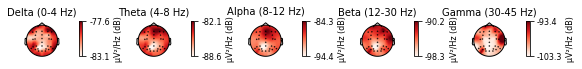

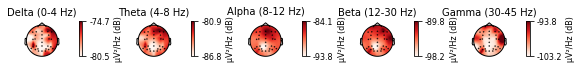

In [11]:
_, axs = plt.subplots(nrows=1, ncols=5, figsize=(8, 4));
rare_epochs.plot_psd_topomap(axes = axs);
_, axs = plt.subplots(nrows=1, ncols=5, figsize=(8, 4));
freq_epochs.plot_psd_topomap(axes = axs);

We see differences in Delta and Theta, which seems correct for P300 and also supported by [1]

[1] Güntekin B, Başar E. A new interpretation of P300 responses upon analysis of coherences. Cogn Neurodyn. 2010;4(2):107-118. doi:10.1007/s11571-010-9106-0

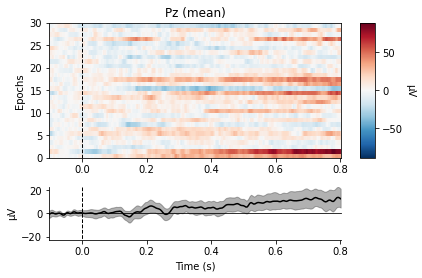

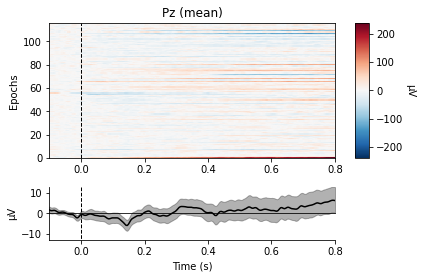

In [12]:
rare_epochs.plot_image(picks=['Pz'], combine='mean');
freq_epochs.plot_image(picks=['Pz'], combine='mean');

We have some brain activity happening around 400-600ms (somewhat partial vertical line) and more dominant brain activity after 600ms for rare epochs. Though, ideally we think it should be around 300-400ms

# Analysing Evokeds

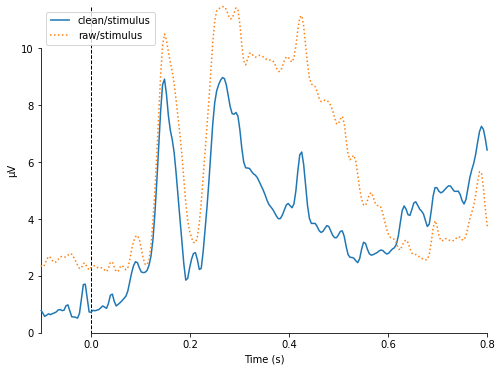

[<Figure size 576x432 with 1 Axes>]

In [13]:
# create epochs without rejecting the bad annotations
epochs_raw = erp.compute_epochs(pipeline.raw, pipeline.events, pipeline.event_ids, set_default=False, reject_by_annotation=False)
# create a copy of current epochs for comparision
epochs_clean = erp.epochs.copy()
# create evoked for stimulus
evoked_raw = epochs_raw['stimulus'].average()
evoked_clean = epochs_clean['stimulus'].average()
# compare raw and clean evokeds with 95% confidence intervals
mne.viz.plot_compare_evokeds({'clean/stimulus': evoked_clean,'raw/stimulus': evoked_raw},  linestyles=['-', ':'], ci=.95)

As we can see from the plot above, rejecting bad annotations helped in removing noise from our evoked responses

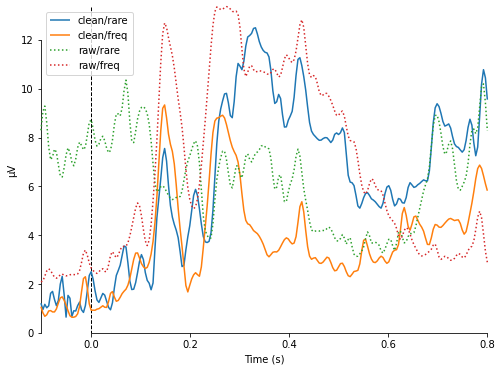

[<Figure size 576x432 with 1 Axes>]

In [14]:
# we will now compare the evoked response for [raw -> rare, freq] and [clean -> rare, freq]
mne.viz.plot_compare_evokeds({'clean/rare': epochs_clean['rare'].average(),
'clean/freq': epochs_clean['freq'].average(),
'raw/rare':epochs_raw['rare'].average(),
'raw/freq': epochs_raw['freq'].average(),
}, linestyles=['-', '-', ':', ':'])

We can see a prolonged activity and significant difference between the rare and freq stimulus or (target and distractors) around 300-400 ms.

In [15]:
# create evoked for rare and freq stimulus
evoked_rare = epochs_clean['rare'].average()
evoked_freq = epochs_clean['freq'].average()

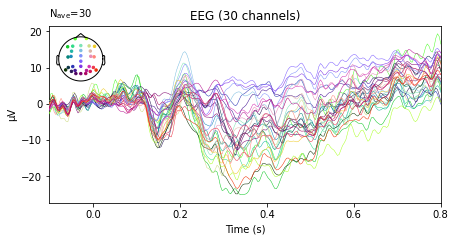

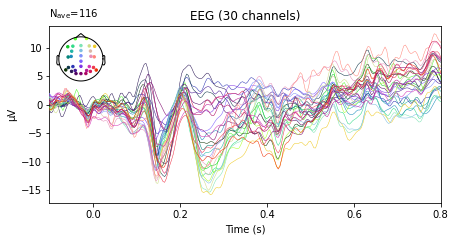

In [16]:
# plot evoked for all channels
evoked_rare.plot(spatial_colors=True);
evoked_freq.plot(spatial_colors=True);

From the evoked plots above, we can see high peak voltage (negative) for few Frontal [Fp1, Fp2, F7, F4] channels for rare stimulus and good difference (`~ 5 µV`) in peak voltage between rare and freq stimulus for Central and Parietal channels [Cz, Pz, CPz]  as compared to freq stimulus,

We will now plot topomaps to see voltage distribution across sculp for rare and freq stimulus for times [-0.1, 0.2, 0.3, 0.4, 0.5]. This is to confirm that there are no other influence around the latency for stimulus onset and stimulus peak difference

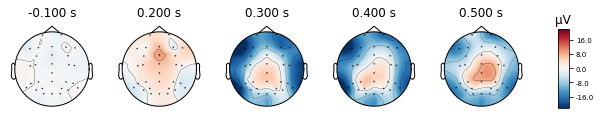

In [17]:
evoked_rare.plot_topomap(times=[-0.1, 0.2, 0.3, 0.4, 0.5], average=0.05);

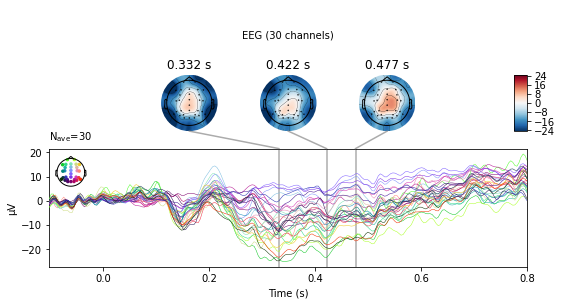

In [18]:
# we see a nice peak around the Central and Parietal regions for rare/target stimulus -- what we wanted to see.
evoked_rare.plot_joint();

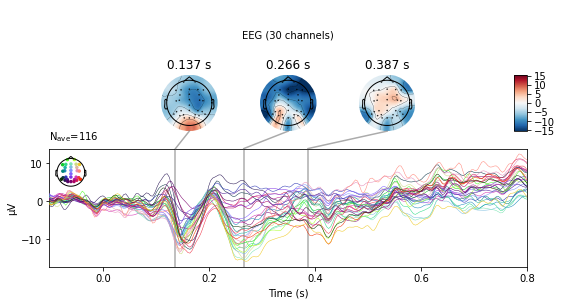

In [19]:
# we see a nice peak around the Central and Parietal regions freq/distractor stimulus which seems less than the amplitude of the rare stimulus
evoked_freq.plot_joint();

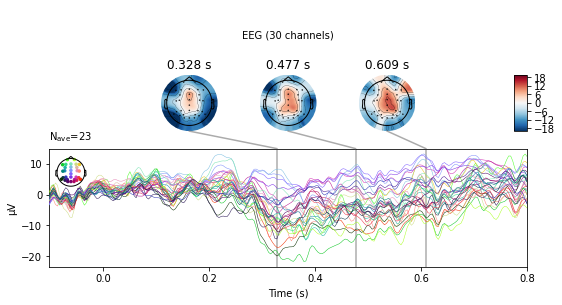

In [20]:
# we will not plot the difference of [rare, freq] evoked responses
rare_minus_freq = mne.combine_evoked([evoked_rare, evoked_freq], weights=[1, -1])
rare_minus_freq.plot_joint();

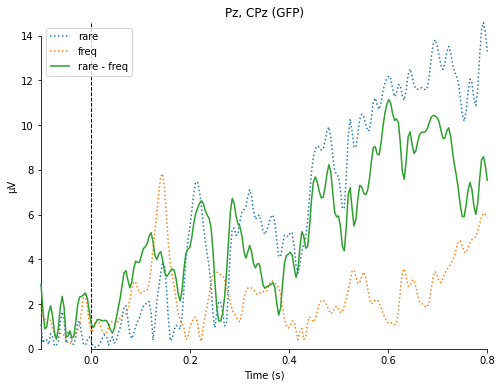

[<Figure size 576x432 with 1 Axes>]

In [21]:
(mne.viz.plot_compare_evokeds(
    {'rare': evoked_rare,'freq': evoked_freq, 'rare - freq': rare_minus_freq},
    picks=["Pz", "CPz"], linestyles=['dotted', 'dotted', 'solid']))

The plot above corroborates thab there is a significant difference between the rare and freq stimulus and we also observe a prolonged difference in the brain activity between these two conditions

## ERP Peak Analysis for all subjects

In [22]:
# we will use the multipipeline to make pipelines for all the subjects which are present in the directory bids_root
pipelines = MultiPipeline(bids_root)
# our new erp analysis object, which supports multiprocessing
erp = ERPAnalysis(tmin, tmax, baseline=baseline, reject_by_annotation=True, all_subjects=True)
# run the preprocessing for subject in parallel
pipelines.start_erp_analysis(erp);

100%|██████████| 40/40 [00:52<00:00,  1.32s/it]


In [23]:
# erp has the list of epochs containing all subjects
len(erp.epochs)

40

## Pipeline Check:

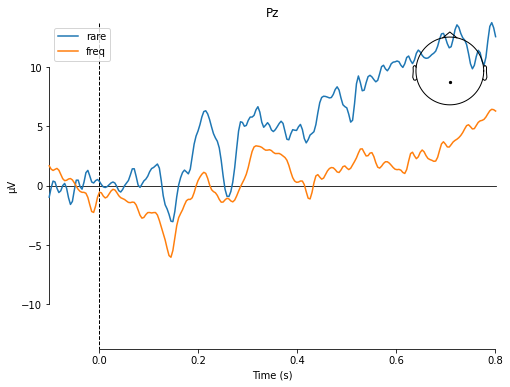

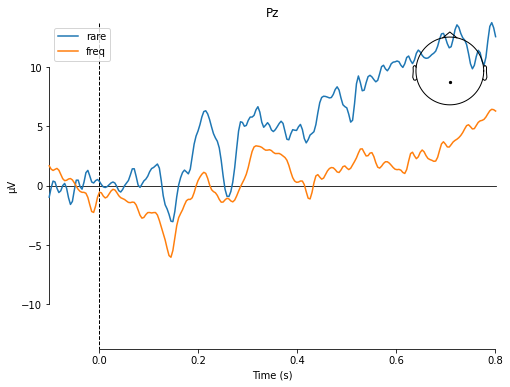

[<Figure size 576x432 with 2 Axes>]

In [24]:
mne.viz.plot_compare_evokeds({'rare': erp.epochs[29]['rare'].average(),'freq':erp.epochs[29]['freq'].average()}, picks="Pz")
mne.viz.plot_compare_evokeds({'rare': epochs_clean['rare'].average(),'freq':epochs_clean['freq'].average()}, picks="Pz")

### We will plot the combine evoked for all the subjects

In [57]:
rare_all = mne.combine_evoked([epochs['rare'].average() for epochs in erp.epochs], weights='nave')
freq_all = mne.combine_evoked([epochs['freq'].average() for epochs in erp.epochs], weights='nave')

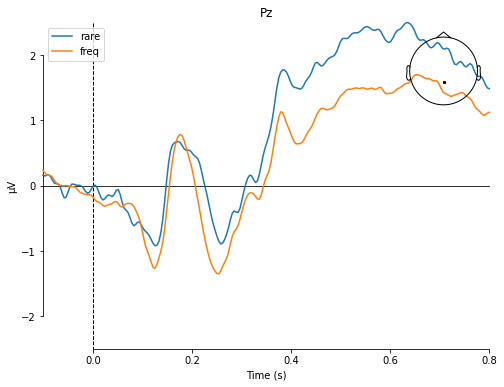

[<Figure size 576x432 with 2 Axes>]

In [62]:
mne.viz.plot_compare_evokeds({'rare': rare_all,'freq': freq_all}, picks=["Pz"], ci=0.95)

# ERP Peak Analysis

`rare_peaks_df` and `freq_peaks_df` contains ERP peaks of all trials

While MNE `evoked.get_peak()` is useful in finding the **location** and **latency** of peak amplitude using the time window provided, it lacks providing support for picking specific channels and mean amplitude values.

Therefore, we will be using our own function for peak value calculation. To get a robust mean amplitude we take a `winsorize` mean to reduce the effect of possibly spurious outliers by limiting the extreme values. For more details check the function definition

Reference: https://erpinfo.org/blog/2018/7/5/mean-versus-peak-amplitude

In [27]:
# here, 0.3s or 300ms is the time point for which I want the peak and 0.1s or 100ms is the padding window. 
# Hence, we it look for peak amplitude betwenn (0.3 - 0.1) to (0.3 + 0.1) seconds
rare_peaks_df = erp.compute_peak('rare', 0.3, 0.1, ['Pz'], 'pos')
freq_peaks_df = erp.compute_peak('freq', 0.3, 0.1, ['Pz'], 'pos')

For example, ERP peaks for Subject 39, we can see the difference between peak and mean amplitude for rare and freq events

In [28]:
# ERP stats of subject 30 - for rare/target stimulus
rare_peaks_df[29].describe()

peak_amp   mean_amp     latency      trial
count  30.000000  30.000000   30.000000  30.000000
mean   17.133333   4.266667  284.866667  14.500000
std    15.584549  13.511000   69.022102   8.803408
min   -22.000000 -30.000000  199.000000   0.000000
25%     9.000000  -3.750000  215.000000   7.250000
50%    14.000000   5.500000  291.000000  14.500000
75%    29.500000  12.000000  347.250000  21.750000
max    43.000000  29.000000  395.000000  29.000000

In [29]:
# ERP stats of subject 30 - for freq/distractor stimulus
freq_peaks_df[29].describe()

peak_amp    mean_amp     latency       trial
count  116.000000  116.000000  116.000000  116.000000
mean    14.120690    1.034483  306.982759   57.500000
std     20.061711   18.925911   63.362173   33.630343
min    -48.000000  -62.000000  199.000000    0.000000
25%      4.000000   -7.000000  248.000000   28.750000
50%     14.000000    1.000000  322.000000   57.500000
75%     21.000000    8.000000  355.000000   86.250000
max    134.000000  108.000000  395.000000  115.000000

### We can similarly plot stats for other subjects.

In the section below, we will compute the differences of peak amplitude and mean amplitude between the conditions for each subject by calculating `rare_peaks_df` - `rare_peaks_df`

In [30]:

from scipy import stats
dfg, peak_p_values, mean_p_values, average_rare_amplitude, average_freq_amplitude = [], [], [], [], []
for rare_df, freq_df in zip(rare_peaks_df, freq_peaks_df):
    inval_col = ['trial', 'stimulus', 'condition', 'channel']
    # perform t-test at individual subject level
    peak_p_values.append(stats.ttest_ind(rare_df['peak_amp'], freq_df['peak_amp'])[1])
    mean_p_values.append(stats.ttest_ind(rare_df['mean_amp'], freq_df['mean_amp'])[1])
    # extract the mean values for individual subjects
    average_rare_amplitude.append(rare_df.mean()[0])
    average_freq_amplitude.append(freq_df.mean()[0])
    # dataframe for looking at difference in conditions for each subject
    dfg.append(rare_df.drop(inval_col, axis=1).subtract(freq_df.drop(inval_col, axis=1)))

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


## P values distrbution plots

<AxesSubplot:ylabel='Count'>

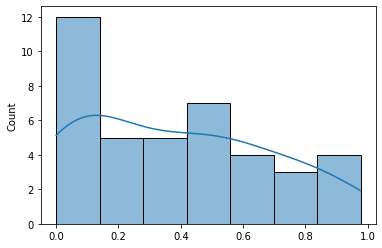

In [31]:
# _, axs = plt.subplots(nrows=1, ncols=2, figsize=(4, 3)); #doesn;t work because of %matplotlib inline
sns.histplot(peak_p_values, kde=True)

<AxesSubplot:ylabel='Count'>

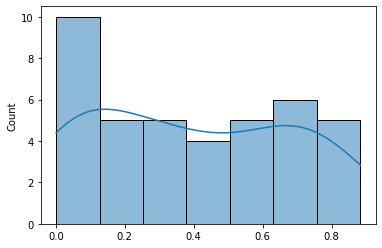

In [32]:
sns.histplot(mean_p_values, kde=True)

In [33]:
# stats of condition difference for subject 40
dfg[39].describe()

peak_amp    mean_amp     latency
count  35.000000   35.000000   35.000000
mean    1.914286    0.371429   -1.342857
std    25.062711   27.219247   90.264625
min   -99.000000 -124.000000 -184.000000
25%    -6.000000   -6.500000  -74.500000
50%     1.000000    2.000000   20.000000
75%    17.000000   16.500000   49.000000
max    33.000000   38.000000  176.000000

### Maximum peak amplitude and mean peak amplitude for difference in condiitons [rare - freq]

In [34]:
# printing peak amplitude and mean amplitude for condition difference for each subject
import pandas as pd
rp_dict = {'sub': [], 'peak_amplitude': [], 'mean_peak_amplitude':[], 'latency': []}
for subj in range(1, len(dfg)+1):
    ttre = dfg[subj-1].mean()
    rp_dict['sub'].append('Sub {}'.format(subj))
    rp_dict['peak_amplitude'].append(ttre[0])
    rp_dict['mean_peak_amplitude'].append(ttre[1])
    rp_dict['latency'].append(ttre[2])
rp_df = pd.DataFrame.from_dict(rp_dict)
rp_df

sub  peak_amplitude  mean_peak_amplitude    latency
0    Sub 1        0.971429             0.514286  -9.000000
1    Sub 2        2.575000             1.825000   9.475000
2    Sub 3        3.314286             2.000000 -20.685714
3    Sub 4        1.800000             0.966667  -1.933333
4    Sub 5        0.125000            -0.050000 -19.175000
5    Sub 6        6.000000             5.350000 -15.250000
6    Sub 7        3.794118             2.205882 -24.529412
7    Sub 8        1.818182             2.227273  -0.227273
8    Sub 9        1.200000             1.533333 -15.733333
9   Sub 10       -2.166667            -1.888889  -2.722222
10  Sub 11        0.825000             0.375000  -7.925000
11  Sub 12        1.225000             1.550000  -0.100000
12  Sub 13        0.487179             0.153846  11.717949
13  Sub 14       -3.545455            -2.863636   9.681818
14  Sub 15       -0.512821            -0.358974 -39.564103
15  Sub 16       -1.175000            -0.800000  13.275000
16  Sub 17        2.179487             2.076923  -4.564103
17  Sub 18        0.710526             0.842105  11.157895
18  Sub 19       -1.100000            -0.550000 -30.525000
19  Sub 20        1.250000             0.700000 -19.450000
20  Sub 21       -3.533333            -5.266667  16.066667
21  Sub 22        0.552632             0.052632  -3.394737
22  Sub 23        0.111111            -0.888889  20.388889
23  Sub 24        0.000000             0.000000  -8.583333
24  Sub 25        2.263158             1.684211  10.736842
25  Sub 26        0.875000            -0.525000  23.325000
26  Sub 27       -0.050000            -0.400000   7.975000
27  Sub 28       -1.424242            -1.181818 -19.787879
28  Sub 29       -3.432432            -3.081081 -13.837838
29  Sub 30        2.233333             1.400000 -29.333333
30  Sub 31        0.758621             0.379310  21.172414
31  Sub 32        0.975000             1.575000 -17.475000
32  Sub 33        2.525000             2.475000  -3.650000
33  Sub 34       -0.270270            -0.108108  23.756757
34  Sub 35        3.518519             3.185185 -15.444444
35  Sub 36       -0.105263             0.394737 -43.078947
36  Sub 37        2.250000             2.200000 -18.950000
37  Sub 38       -0.600000            -0.257143 -21.257143
38  Sub 39       -0.475000            -1.625000   9.025000
39  Sub 40        1.914286             0.371429  -1.342857

# T- Test for all subjects by taking average

In [35]:
# average_rare_amplitude
stats.ttest_ind(average_rare_amplitude, average_freq_amplitude)

Ttest_indResult(statistic=0.7679075298332746, pvalue=0.4448606695012677)

Ideally we were expecting a value less the 0.1 or 0.2


But based on what we have, we can't reject the null hypothesis that there is a significant difference between conditions `rare` and `freq`

# T- Test for all subjects without taking average

### Let's calculate T-test again without taking average

In [36]:
rare_df = pd.concat(rare_peaks_df, ignore_index=True)
freq_df = pd.concat(freq_peaks_df, ignore_index=True)
rare_df.describe()

peak_amp     mean_amp      latency        trial
count  1370.000000  1370.000000  1370.000000  1370.000000
mean      6.965693     0.194891   304.693431    17.429197
std       6.978386     6.498579    68.428554    10.914223
min     -82.000000  -112.000000   199.000000     0.000000
25%       3.000000    -3.000000   234.000000     8.000000
50%       6.000000     0.000000   312.000000    17.000000
75%      10.000000     3.000000   371.000000    26.000000
max      46.000000    32.000000   395.000000    39.000000

In [37]:
freq_df.describe()

peak_amp     mean_amp      latency        trial
count  5463.000000  5463.000000  5463.000000  5463.000000
mean      6.433828    -0.278785   307.794252    71.217646
std       6.702877     6.150505    68.420661    43.832414
min     -58.000000  -101.000000   199.000000     0.000000
25%       3.000000    -3.000000   238.000000    34.000000
50%       6.000000     0.000000   320.000000    68.000000
75%       9.000000     3.000000   371.000000   108.000000
max     134.000000   108.000000   395.000000   159.000000

In [38]:
stats.ttest_ind(rare_df['mean_amp'], freq_df['mean_amp'])

Ttest_indResult(statistic=2.5196084706155606, pvalue=0.01177116612660162)

### Seems like our p-value is improved. It is 0.01 which is less than 0.05. Hence, we can say there is a significant difference between rare and freq stimulus

# We will do some further analysis to see if we are missing something

In [39]:
peak_df = pd.concat([rare_df, freq_df], ignore_index=True)

### Plotting only on condition: `Rare`, `Freq`

<AxesSubplot:xlabel='latency', ylabel='Density'>

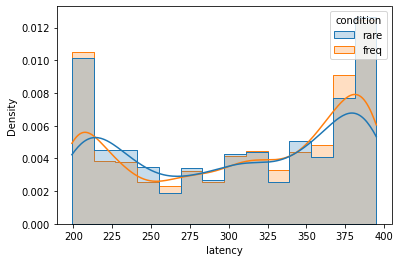

In [40]:
import seaborn as sns
sns.histplot(peak_df, x='latency', hue='condition', kde=True, element="step",
    stat="density", common_norm=False)

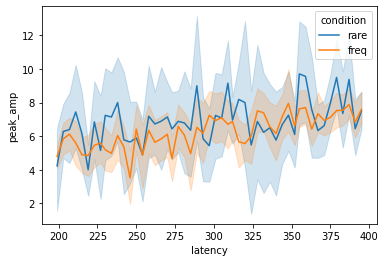

In [41]:
ax = sns.lineplot(x="latency", y="peak_amp", data=peak_df, hue='condition')

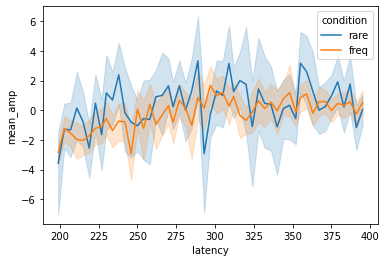

In [42]:
ax = sns.lineplot(x="latency", y="mean_amp", data=peak_df, hue='condition')

<AxesSubplot:xlabel='peak_amplitude', ylabel='mean_peak_amplitude'>

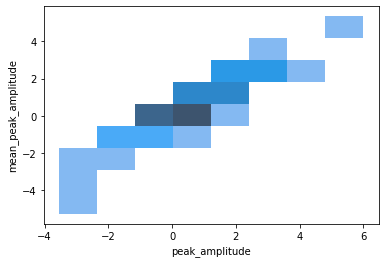

In [43]:
sns.histplot(data=rp_df, x='peak_amplitude', y='mean_peak_amplitude')

## Let's see for both condition [rare, freq] and stimulus [A, B, C, D, E]

In [44]:
A_rare_peaks = pd.concat(erp.compute_peak('A/rare', 0.3, 0.1, ['Pz', 'Cpz']), ignore_index=True)
A_freq_peaks = pd.concat(erp.compute_peak('A/freq', 0.3, 0.1, ['Pz', 'Cpz']), ignore_index=True)
B_rare_peaks = pd.concat(erp.compute_peak('B/rare', 0.3, 0.1, ['Pz', 'Cpz']), ignore_index=True)
B_freq_peaks = pd.concat(erp.compute_peak('B/freq', 0.3, 0.1, ['Pz', 'Cpz']), ignore_index=True)
C_rare_peaks = pd.concat(erp.compute_peak('C/rare', 0.3, 0.1, ['Pz', 'Cpz']), ignore_index=True)
C_freq_peaks = pd.concat(erp.compute_peak('C/freq', 0.3, 0.1, ['Pz', 'Cpz']), ignore_index=True)
D_rare_peaks = pd.concat(erp.compute_peak('D/rare', 0.3, 0.1, ['Pz', 'Cpz']), ignore_index=True)
D_freq_peaks = pd.concat(erp.compute_peak('D/freq', 0.3, 0.1, ['Pz', 'Cpz']), ignore_index=True)
E_rare_peaks = pd.concat(erp.compute_peak('E/rare', 0.3, 0.1, ['Pz', 'Cpz']), ignore_index=True)
E_freq_peaks = pd.concat(erp.compute_peak('E/freq', 0.3, 0.1, ['Pz', 'Cpz']), ignore_index=True)


We will contact all of them

In [45]:
all_peaks = pd.concat([
A_rare_peaks,
A_freq_peaks,
B_rare_peaks,
B_freq_peaks,
C_rare_peaks,
C_freq_peaks,
D_rare_peaks,
D_freq_peaks,
E_rare_peaks,
E_freq_peaks,
], ignore_index=True)

[(-50.0, 50.0)]

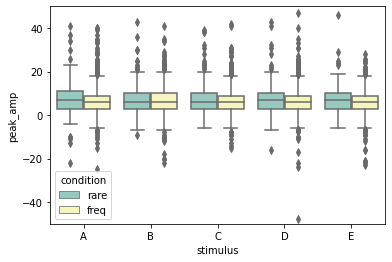

In [46]:
ax = sns.boxplot(x="stimulus", y="peak_amp", hue="condition",  data=all_peaks, palette="Set3")
ax.set(ylim=(-50, 50))

[(-50.0, 50.0)]

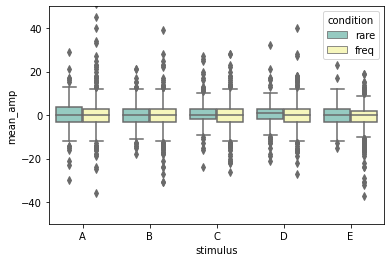

In [47]:
ax = sns.boxplot(x="stimulus", y="mean_amp", hue="condition",  data=all_peaks, palette="Set3")
ax.set(ylim=(-50, 50))

From the plots above, we see a very small difference between the mean and peak amplitude for rare and freq stimulus. Idealy, we wan to see the mean and peak amplitudes of rare stimulus higher than the freq stimulus

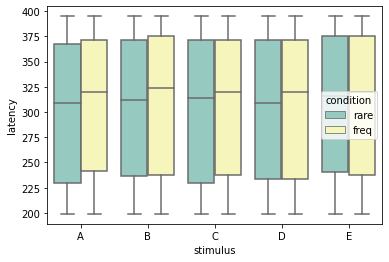

In [48]:
ax = sns.boxplot(x="stimulus", y="latency", hue="condition",  data=all_peaks, palette="Set3")

It is strange to observe that `rare/target` events have low mean latency than `freq/distractor` events for all stimulus

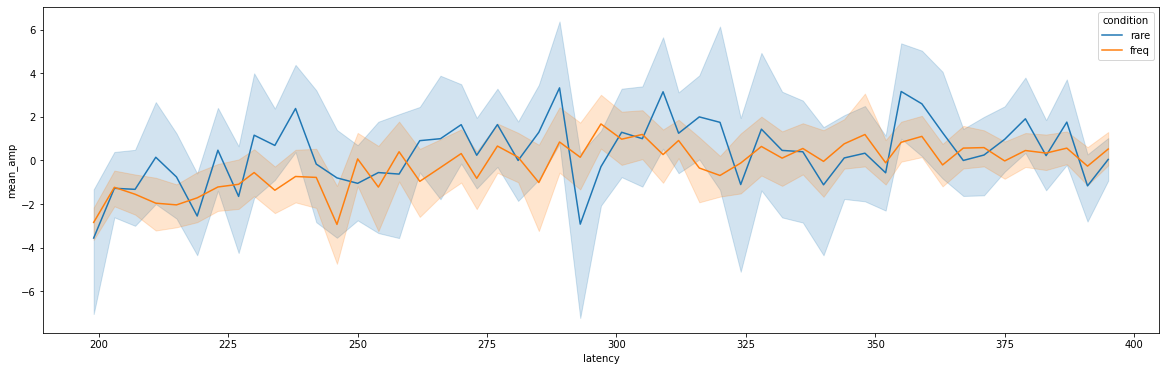

In [49]:
_, axs = plt.subplots(nrows=1, ncols=1, figsize=(20, 6));
axs = sns.lineplot(x="latency", y="mean_amp", data=all_peaks, hue='condition')

The voltage drop around 300ms seems quite strange for rare stimulus!

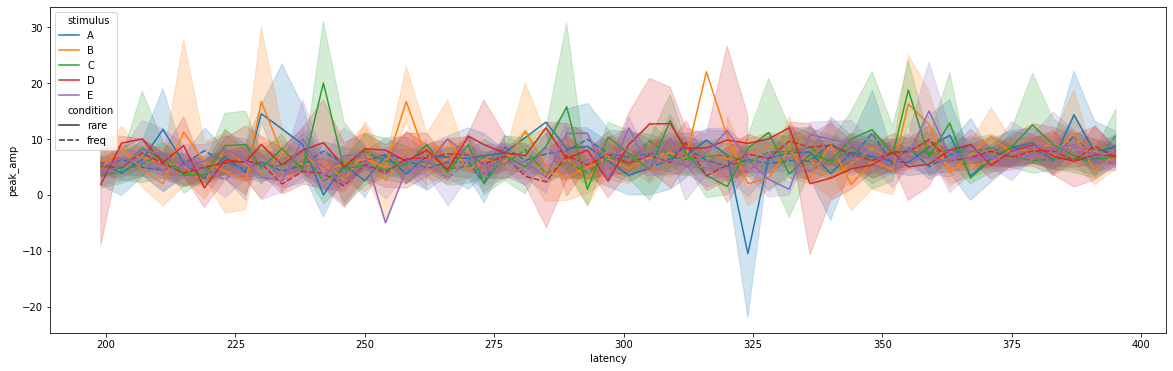

In [50]:
_, axs = plt.subplots(nrows=1, ncols=1, figsize=(20, 6));
axs = sns.lineplot(x="latency", y="peak_amp", data=all_peaks, hue='stimulus', style="condition")

## TO see whether stimulus A, B, C, D are independent, we will plot their distributions

<AxesSubplot:xlabel='mean_amp', ylabel='Density'>

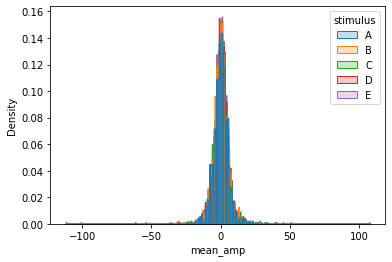

In [51]:
sns.histplot(
    all_peaks, x="mean_amp", hue="stimulus", element="step",
    stat="density", common_norm=False,
)

<AxesSubplot:xlabel='peak_amp', ylabel='Density'>

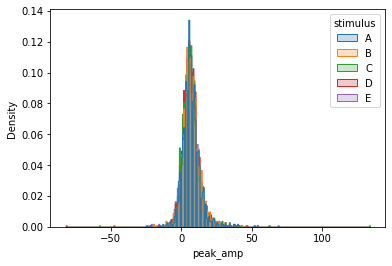

In [52]:
sns.histplot(
    all_peaks, x="peak_amp", hue="stimulus", element="step",
    stat="density", common_norm=False
    )